In [44]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import rosbag
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
from IPython.display import display
from mpldatacursor import datacursor
import time
import math
import cv2
from cv_bridge import CvBridge

In [45]:
#READ BAG

#When recording rosbag follow this sequence:
# 1. rosparam set use_sim_time true
# 3. roslaunch darkentros yolov3.launch
# 4. roslaunch scooter record_data.launch
# 2. rosbag play 2019-02-11-Wentworth-P7.bag /cam_1/color/image_raw:=/cam /cam_2/color/image_raw:=/cam --clock



filename='2019-04-24-MSY-P1-yolo'

bag  = rosbag.Bag('/home/maleen/rosbags/' + filename + '.bag')

In [46]:
#READ TOPICS

encsize=0
imusize=0
rtkllasize=0
rtkenusize=0

yolosize=0
yolosize2=0

encoder_time=np.array([])
encoder_seq=np.array([])
encoder_x=np.array([])
encoder_y=np.array([])

imureal_time=np.array([])
imureal_seq=np.array([])
imureal_angvZ=np.array([])
imureal_angvX=np.array([])
imureal_angvY=np.array([])

rtklla_time=np.array([])
rtklla_seq=np.array([])
rtklla_lat=np.array([])
rtklla_long=np.array([])
rtklla_alti=np.array([])

rtkenu_time=np.array([])
rtkenu_seq=np.array([])
rtkenu_x=np.array([])
rtkenu_y=np.array([])
rtkenu_z=np.array([])

yolo_time=np.array([])
yolo_seq=np.array([])
image_time=np.array([])
image_seq=np.array([])
image_frame=np.array([])
bounding_box=[]
detectimg_time=np.array([])
detectimg=np.array([])
foundobj=np.array([])
foundobj_time=np.array([])


yolo_time2=np.array([])
yolo_seq2=np.array([])
image_time2=np.array([])
image_seq2=np.array([])
bounding_box2=[]
detectimg_time2=np.array([])
detectimg2=np.array([])
foundobj2=np.array([])
foundobj_time2=np.array([])

overall_time=np.array([])
labels=np.array([])

laser_time=np.array([])
laser_data=np.array([])
laser_ranges=np.array([])


topiclist=['/encoder_ticks','/casimu/imureal','/piksi/navsatfix_best_fix' ,'/piksi/enu_pose_best_fix','/darknet_ros/bounding_boxes','/darknet_ros/detection_image', '/darknet_ros/found_object'
,'/scan']

for topic, msg, t in bag.read_messages(topics=topiclist): #
    
        if topic=='/encoder_ticks':
            
            encoder_time=np.append(encoder_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            encoder_seq=np.append(encoder_seq,msg.header.seq)
            encoder_x=np.append(encoder_x,-msg.ticks.x)
            encoder_y=np.append(encoder_y,-msg.ticks.y)
            encsize=encsize+1
            overall_time=np.append(overall_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            labels=np.append(labels,'O')
            
        elif topic=='/casimu/imureal':
        
            imureal_time=np.append(imureal_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            imureal_seq=np.append(imureal_seq,msg.header.seq)
            #print msg
            imureal_angvZ=np.append(imureal_angvZ,(msg.angular_velocity.z))
            imureal_angvX=np.append(imureal_angvX,(msg.angular_velocity.x))
            imureal_angvY=np.append(imureal_angvY,(msg.angular_velocity.y))
            imusize=imusize+1
            
        elif topic=='/piksi/navsatfix_best_fix':
        
            rtklla_time=np.append(rtklla_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            rtklla_seq=np.append(rtklla_seq,msg.header.seq)
            #print msg
            rtklla_lat=np.append(rtklla_lat,(msg.latitude))
            rtklla_long=np.append(rtklla_long,(msg.longitude))
            rtklla_alti=np.append(rtklla_alti,(msg.altitude))
            rtkllasize=rtkllasize+1
            
            
        elif topic=='/piksi/enu_pose_best_fix':
        
            rtkenu_time=np.append(rtkenu_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            rtkenu_seq=np.append(rtkenu_seq,msg.header.seq)
            rtkenu_x=np.append(rtkenu_x,(msg.pose.pose.position.x))
            rtkenu_y=np.append(rtkenu_y,(msg.pose.pose.position.y))
            rtkenu_z=np.append(rtkenu_z,(msg.pose.pose.position.z))
            rtkenusize=rtkenusize+1
            #print msg
        
            
        #CAMERA 01    

        elif topic=='/darknet_ros/bounding_boxes':
            
            yolo_time=np.append(yolo_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            yolo_seq=np.append(yolo_seq,msg.header.seq)

            
            image_time=np.append(image_time,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
            image_seq=np.append(image_seq,msg.image_header.seq)
            frame=msg.image_header.frame_id
            
                        
            bounding_box.append(msg.bounding_boxes)
            
            overall_time=np.append(overall_time,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
            
            if frame=='cam_1_color_optical_frame':
            
                labels=np.append(labels,'C1')
                image_frame=np.append(image_frame,'C1')
                
            elif frame=='cam_2_color_optical_frame':
            
                labels=np.append(labels,'C2')
                image_frame=np.append(image_frame,'C2')
            
        elif topic=='/darknet_ros/detection_image':
            
            #cv_image = bridge.imgmsg_to_cv2(msg.data, desired_encoding="passthrough")
        
            detectimg_time=np.append(detectimg_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            detectimg=np.append(detectimg,msg)
            yolosize=yolosize+1
            
        elif topic=='/darknet_ros/found_object':
           
            foundobj=np.append(foundobj,msg.data)
            
            
        elif topic=='/scan':
        
            laser_time=np.append(laser_time,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
            laser_data=np.append(laser_data,msg)
            laser_ranges=np.append(laser_ranges,msg.ranges)
            labels=np.append(labels,'L')
            
         #CAMERA 02
            
     
        #elif topic=='/darknet_ros_2/bounding_boxes':
            
        #    yolo_time2=np.append(yolo_time2,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
        #    yolo_seq2=np.append(yolo_seq2,msg.header.seq)
            
        #    image_time2=np.append(image_time2,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
        #    image_seq2=np.append(image_seq2,msg.image_header.seq)
            
        #    bounding_box2.append(msg.bounding_boxes)
            
        #    overall_time=np.append(overall_time,(msg.image_header.stamp.secs)+(Decimal(msg.image_header.stamp.nsecs)/1000000000))
        #    labels=np.append(labels,'C2')
            
        #elif topic=='/darknet_ros_2/detection_image':
            
            #cv_image = bridge.imgmsg_to_cv2(msg.data, desired_encoding="passthrough")
        
        #    detectimg_time2=np.append(detectimg_time2,(msg.header.stamp.secs)+(Decimal(msg.header.stamp.nsecs)/1000000000))
        #    detectimg2=np.append(detectimg2,msg)
         #   yolosize2=yolosize2+1
            
        #elif topic=='/darknet_ros_2/found_object':
           
         #   foundobj2=np.append(foundobj2,msg.data)
            
   

In [47]:
#BRING DATA TO ENCODER TIME

imureal_time=imureal_time-encoder_time[0]
rtklla_time=rtklla_time-encoder_time[0]
rtkenu_time=rtkenu_time-encoder_time[0]

yolo_time=yolo_time-encoder_time[0]
image_time=image_time-encoder_time[0]
#yolo_time2=yolo_time2-encoder_time[0]
#image_time2=image_time2-encoder_time[0]

overall_time=overall_time-encoder_time[0]
laser_time=laser_time-encoder_time[0]


encoder_time=encoder_time-encoder_time[0]

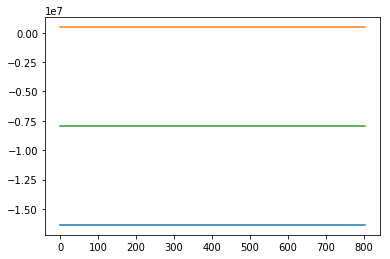

In [48]:
#PROCESS ENCODER DATA

x=0
y=0
sign_x=0
sign_y=0

diffarray=np.array([])

for x in range(1,encoder_x.size-1):
    
    diff=encoder_x[x]-encoder_x[x-1]

    if abs(diff) > 16770000:
              
        sign_x=1
        changevalx=encoder_x[x-1]
        encoder_x[x]=encoder_x[x]+changevalx
           
        
    if sign_x==1:
    
        encoder_x[x+1]=encoder_x[x+1]+changevalx

        
for y in range(1,encoder_y.size-1):
    
    
    diff=encoder_y[y]-encoder_y[y-1]
    diffarray=np.append(diffarray,diff)

    if abs(diff) > 16770000:
              
        sign_y=1
        changevaly=diff
        encoder_y[y]=encoder_y[y]-changevaly   
        
        
    if sign_y==1:
    
        encoder_y[y+1]=encoder_y[y+1]-changevaly

encoder_mean=(encoder_x-encoder_y)/2
encoder_y=-encoder_y

encoderdata={'encoder_seq':encoder_seq, 'encoder_time':encoder_time, 'encoder_x':encoder_x, 'encoder_y':encoder_y, 'encoder_mean':encoder_mean}
encoder_df = pd.DataFrame(encoderdata, columns=['encoder_seq','encoder_time','encoder_x','encoder_y','encoder_mean'])
#print encoder_df

plt.plot(encoder_x)
plt.plot(encoder_y)
plt.plot(encoder_mean)



In [49]:
#PROCESS YOLO DATA

#FILTER OUT DETECTED IMAGES

bridge = CvBridge()
detected_images=[]
#detected_images2=[]

x1=0


for num in foundobj:
    
    if num>0 and x1<detectimg.size:
        
        cv_image = bridge.imgmsg_to_cv2(detectimg[x1], desired_encoding="passthrough")
        detected_images.append(cv_image)
    
    x1=x1+1
    
#for num in foundobj2:
    
#    if num>0:

#        cv_image = bridge.imgmsg_to_cv2(detectimg2[x2], desired_encoding="passthrough")
#        detected_images2.append(cv_image)
    
#    x2=x2+1
    


yolodata={'yolo_seq':yolo_seq, 'yolo_time':yolo_time,'image_seq':image_seq, 'image_time':image_time,'image_frame':image_frame,'bounding_box':bounding_box}
yolo_df = pd.DataFrame(yolodata, columns=['yolo_seq','yolo_time','image_seq','image_time','image_frame','bounding_box'])

#yolodata2={'yolo_seq2':yolo_seq2, 'yolo_time2':yolo_time2,'image_seq2':image_seq2, 'image_time2':image_time2,'bounding_box2':bounding_box2}
#yolo_df2 = pd.DataFrame(yolodata2, columns=['yolo_seq2','yolo_time2','image_seq2','image_time2','bounding_box2'])



#print yolo_df

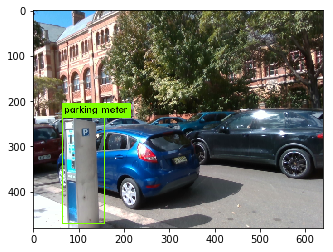

In [50]:
#TEST DETECTED IMAGES

plt.imshow(cv2.cvtColor(detected_images[10], cv2.COLOR_BGR2RGB))
#plt.imshow(detected_images[25])
plt.show()

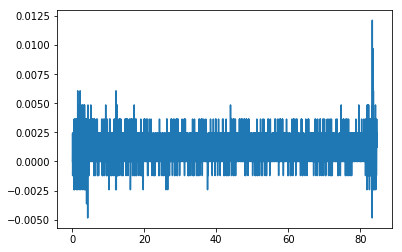

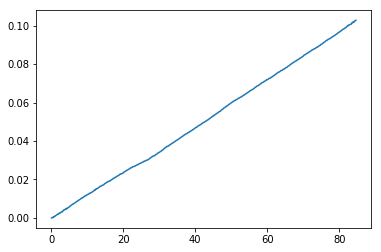

In [51]:
#PROCESS IMU DATA

imureal_angvZ=imureal_angvZ-imureal_angvZ[0]
imureal_angvX=imureal_angvX-imureal_angvX[0]
imureal_angvY=imureal_angvY-imureal_angvY[0]

plt.figure(1)
plt.plot(imureal_time,-imureal_angvZ)
thetaZ=integrate.cumtrapz(-imureal_angvZ,np.float64(imureal_time),initial=0)
thetaX=integrate.cumtrapz(imureal_angvX,np.float64(imureal_time),initial=0)
thetaY=integrate.cumtrapz(imureal_angvY,np.float64(imureal_time),initial=0)

plt.figure(2)
plt.plot(imureal_time,thetaZ)
#plt.plot(imureal_time,thetaX)
#plt.plot(imureal_time,thetaY)

imudata={'imureal_time':imureal_time, 'imureal_angvZ':-imureal_angvZ, 'thetaZ':thetaZ}
imu_df = pd.DataFrame(imudata,columns=['imureal_time','imureal_angvZ','thetaZ'])

In [52]:
#OBTAIN ENCODER DISTANCES

dist=0

encXcalib=6.608284615932709e-05;
encYcalib=6.603486193757895e-05;
mean_calib=np.mean([encXcalib,encYcalib])

enc_dist=np.array([])
enc_times=np.array([])

mean_enctime=np.array([])


for enciter in range(1,encoder_mean.size):

    
    dist=(encoder_mean[enciter]-encoder_mean[enciter-1])*mean_calib
    
    enc_dist=np.append(enc_dist,dist)
    
    enc_times=np.append(enc_times, encoder_time[enciter])
    
    mean_enctime=np.append(mean_enctime,(encoder_time[enciter]+encoder_time[enciter-1])/2)
    


In [53]:
#INTERPOLATE THETA Z

thetaZ_interp=interp1d(np.float64(imureal_time), thetaZ, kind='linear')

#print thetaZ_interp(np.float64(mean_enctime))

#print enc_dist

In [54]:
#mean_theta=mean_theta-mean_theta[0]
#plt.rcParams['figure.figsize'] = [50,50]

thetaZ_samp=thetaZ_interp(np.float64(mean_enctime))
THETA_pos=thetaZ_interp(np.float64(enc_times))

dx=np.multiply(enc_dist,np.cos(THETA_pos))
dy=np.multiply(enc_dist,np.sin(THETA_pos))
Xd=0
Yd=0

X_pos=np.array([])
Y_pos=np.array([])


for num in range(0,encoder_mean.size-1):
    
    Xd=Xd+dx[num]
    Yd=Yd+dy[num]
    
    X_pos=np.append(X_pos,Xd)
    Y_pos=np.append(Y_pos,Yd)

    
plt.plot(X_pos,Y_pos)
plt.axis('equal')
plt.title('Path')
datacursor()
plt.show()


odomdata={'mean_enctime':mean_enctime,'enc_dist':enc_dist,'thetaZ_samp':thetaZ_samp,'enc_times':enc_times, 'X_pos':X_pos, 'Y_pos':Y_pos,'THETA_pos':THETA_pos}
odom_df = pd.DataFrame(odomdata,columns=['mean_enctime','enc_dist','thetaZ_samp','enc_times', 'X_pos','Y_pos','THETA_pos'])

ValueError: A value in x_new is below the interpolation range.

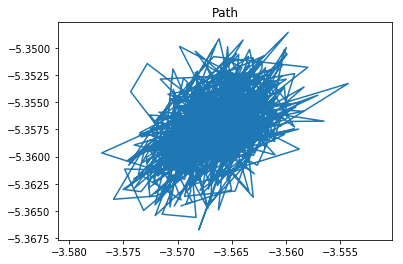

In [55]:
#INTERPOLATE THETA RTK_ENU

rtkenu_x_interp=interp1d(np.float64(rtkenu_time), rtkenu_x, kind='linear')
rtkenu_y_interp=interp1d(np.float64(rtkenu_time), rtkenu_y, kind='linear')
rtkenu_z_interp=interp1d(np.float64(rtkenu_time), rtkenu_z, kind='linear')


rtkenu_x_samp=rtkenu_x_interp(np.float64(rtkenu_time))
rtkenu_y_samp=rtkenu_y_interp(np.float64(rtkenu_time))
rtkenu_z_samp=rtkenu_z_interp(np.float64(rtkenu_time))


plt.plot(rtkenu_x_samp,rtkenu_y_samp)
plt.axis('equal')
plt.title('Path')
datacursor()
plt.show()



In [56]:
RTKdata={'rtk_time':rtklla_time,'rtklla_lat':rtklla_lat,'rtklla_long':rtklla_long,'rtklla_alti':rtklla_alti}
RTK_df = pd.DataFrame(RTKdata,columns=['rtk_time','rtklla_lat','rtklla_long','rtklla_alti'])

In [57]:
#EXTRACT YOLO DATA

lamp_dimensions=np.array([])
lamp_times=np.array([])
yolo_index=np.array([])
camera=np.array([])

#lamp_dimensions2=np.array([])
#lamp_times2=np.array([])
#yolo_index2=np.array([])


for row_index,row in yolo_df.iterrows():
    
        for obj in row[5]:
             if obj.Class=='post'  or  obj.Class=='parking meter' or  obj.Class=='tree' or  obj.Class=='street sign'or  obj.Class=='streetlamp':
               #or  obj.Class=='tree'
                print obj.Class
                if row[3]>mean_enctime[0] and row[3]<mean_enctime[-1]:
                    lamp_dimensions=np.append(lamp_dimensions,[obj.xmin,obj.ymin,obj.xmax,obj.ymax])
                    lamp_times=np.append(lamp_times,row[3])
                    yolo_index=np.append(yolo_index, row[0]) 
                    camera=np.append(camera,row[4])
                    
lamp_dimensions=np.reshape(lamp_dimensions, (lamp_dimensions.size/4, 4))  
                    
#for row_index,row in yolo_df2.iterrows():
    
#        for obj in row[4]:
#             if obj.Class=='streetlamp':
#                if row[3]>mean_enctime[0] and row[3]<mean_enctime[-1]:
#                    lamp_dimensions2=np.append(lamp_dimensions2,[obj.xmin,obj.ymin,obj.xmax,obj.ymax])
#                    lamp_times2=np.append(lamp_times2,row[3])
#                    yolo_index2=np.append(yolo_index2, row[0]) 
                    
#lamp_dimensions2=np.reshape(lamp_dimensions2, (lamp_dimensions2.size/4, 4))  
                    

parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
post
post
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
post
pos

parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
parking meter
post
post
parking meter
parking meter
parking meter
parkin

In [58]:
def getyolobearing(dimensions):
    
    h_fov=np.deg2rad(69.4)
    h_width=640
    centerX=h_width/2
    
    rad_per_pix=h_fov/h_width

    centroids=np.zeros((dimensions.shape[0],2))
    bearings=np.zeros(dimensions.shape[0])
    gradients=np.zeros(dimensions.shape[0])
    intercepts=np.zeros(dimensions.shape[0])
    
  
    centroids[:,0]=(dimensions[:,0]+dimensions[:,2])/2
    centroids[:,1]=(dimensions[:,1]+dimensions[:,3])/2
    
    bearings=(centroids[:,0]-centerX)*rad_per_pix
    gradients=np.tan(bearings)
    
    return bearings,centroids

In [59]:
bearings,centroids=getyolobearing(lamp_dimensions) 
#bearings2,centroids2=getyolobearing(lamp_dimensions2)


lampdata={'yolo_index':yolo_index,'lamp_times':lamp_times,'camera':camera,'bearings':bearings,'centroid_x':centroids[:,0],'centroid_y':centroids[:,1]}
lampdata_df= pd.DataFrame(lampdata,columns=['yolo_index','lamp_times','camera','bearings','centroid_x','centroid_y'])

#lampdata2={'yolo_index2':yolo_index2,'lamp_times2':lamp_times2,'bearings2':bearings2,'centroid_x2':centroids2[:,0],'centroid_y2':centroids2[:,1]}
#lampdata_df2 = pd.DataFrame(lampdata2,columns=['yolo_index2','lamp_times2','bearings2','centroid_x2','centroid_y2'])